
## ECOPs AFRICA OCEAN COLOUR TRAINING

### M2-L1: Data manipulation and analysis
<span style="color:brown; font-size:1.2em;font-style:italic">Part 1.1 resampling and visualization</span>
<hr style="border:2px solid rgb(30,70,125)"> </hr>


<span style="font-size:1.1em;">Eligio Maure (maure@npec.or.jp)</span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Data resampling](#3.-Data-resampling)
    - [3.1 Define target projection](#3.1-Define-target-projection)
    - [3.2 Define target resample area](#3.2-Define-target-resample-area)
    - [3.3 Define resampling function](#3.3-Define-resampling-function)
    - [3.4 Screen and project data](#3.4-Screen-and-project-data)
- [4. Visualize result](#4.-Visualize-result)
- [5. Resources](#5.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

In this exercise you will learn to
- resample or reproject unprojected swath image into a new target geographic projection and area.

As you saw in M1L1, swath are unprojected images. By resampling swath we can easily create composite images or display them in a map without distortions.

***

# 2. Library import
[Return to the "Table of contents"](#Table-of-contents)

In [1]:
# dateutil
from datetime import datetime

# Data manipulation
import h5py
import numpy as np

# Geospatial
import pyproj
from cartopy import crs as ccrs, feature as cfeature
from pyresample.geometry import SwathDefinition
from pyresample.area_config import create_area_def
from pyresample.kd_tree import resample_nearest

# System
import sys
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

Matplotlib comes with defaults parameters used for plotting and visualization.   
For example, during instantiation of figures in Matplotlib, often we pass `figsize` parameter to `plt.figure`. <br>
Matplotlib can also be customized to override the default values using rc (runtime configuration) settings.
***

In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12, 11)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.facecolor'] = '0.8'
# plt.rcParams['figure.constrained_layout.use'] = True

- **Local modules**  

Include a local library (scripts) with custom fuctions.  

We use the `sys` module to append a directory to the list of known paths for interpreter to search.  
This allow us to import the custom functions or modules not in the search directories.

We also use the `Path` library to help us get the name of the current working directory.

---

In [3]:
# appending a path
cwd = Path.cwd()
sys.path.append(str(cwd.parent))

import octutils as util

In [4]:
# Define parameters
start = datetime(2022, 5, 25)
end = datetime(2022, 5, 25)
bbox = 30, -30, 50, -10
sensor = 'sgli'
dtype = 'OC' # OC, SST, RRS (nwlr)

In [5]:
# search for a given bbox and time
files = util.getfile(start_date=start, 
                     end_date=end, 
                     bbox=bbox, 
                     sensor=sensor, 
                     dtype=dtype)
print('\n'.join(f'{i+1:02}: {f.name}' for i, f in enumerate(files)))

01: GC1SG1_202205250725U16613_L2SG_IWPRQ_3000.h5
02: GC1SG1_202205250730D16614_L2SG_IWPRQ_3000.h5
03: GC1SG1_202205250734H16615_L2SG_IWPRQ_3000.h5


# 3. Data resampling
[Return to the "Table of contents"](#Table-of-contents)   
## 3.1 Define target projection

Satellite swath data comes with no projection. So, as a first step, we create a function that define the target projection for our swath data. Since swath data comes with a given spatial resolution, say 250 m or 1 km, in this exercise we are going to use a projection that is conservative for the pixel resolution, i.e., Lambert azimuthal equal-area ([laea](https://pro.arcgis.com/en/pro-app/2.8/help/mapping/properties/lambert-azimuthal-equal-area.htm#:~:text=Lambert%20azimuthal%20equal%2Darea%20is,angles%20between%20them%20are%20true.)).    

In [6]:
def get_proj(lon_0, lat_0, description, proj_name, datum):
    """
    Returns a pyproj object with a projected spatial reference system (srs) information. 
    
    
    Parameters
    ----------
    lon_0: float
        central longitude 
    lat_0: float
        central latitude
    description: str
        description
    proj_name: str
        projection name        
    datum: str
        The name of the datum. (e.g., WGS88: World Geodetic System 1984).

    Returns
    -------
    projection: pyproj.Proj
        Projection object
    """
    projection = dict(datum=datum,
                      description=description,
                      lat_0=lat_0,
                      lon_0=lon_0,
                      proj=proj_name)
    return pyproj.Proj(projection)

In [7]:
proj_name = 'laea' # Lambert azimuthal equal-area, you can also use lon/lat
datum = 'WGS84'
description = 'Antarctic EASE grid'

lon_0 = np.mean([bbox[0], bbox[2]])
lat_0 = np.mean([bbox[1], bbox[3]])

# You can check the lons/lats of the centre points
proj = get_proj(lat_0=lat_0, 
                lon_0=lon_0, 
                proj_name=proj_name,
                datum=datum, 
                description=description)
proj.srs, proj(lon_0, lat_0)

('+proj=laea +lat_0=-20 +lon_0=40 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',
 (0.0, 0.0))

## 3.2 Define target resample area
[Return to the "Table of contents"](#Table-of-contents)   

Satellite swath data comes with no projection. So, as a first step, we create a function that define the target projection for our swath data. Once the data have the same projected we can then easily composite. Since swath data comes with a given spatial resolution, in this exercise we are going to use a projection that is conservative for the pixel resolution.

In [8]:
def get_area_definition(area_id, projection, area_extent, resolution, 
                        units, width=None, height=None):
    """
    Returns a uniformly spaced geographic region to be used in resampling (the target area). 
    The projection for an area is typically described by longitude/latitude coordinates or  
    described in X/Y coordinates in meters. 
    see https://pyresample.readthedocs.io/en/latest/geo_def.html#areadefinition
    
    Parameters
    ----------
    area_id: str
        ID of the area
    projection: str
        Proj4 parameters as a dict or string
    area_extent: tuple
        lower_left_x, lower_left_y, upper_right_x, upper_right_y
        where
        lower_left_x: projection x coordinate of lower left corner of lower left pixel
        lower_left_y: projection y coordinate of lower left corner of lower left pixel
        upper_right_x: projection x coordinate of upper right corner of upper right pixel
        upper_right_y: projection y coordinate of upper right corner of upper right pixel
    resolution: list | float
        pixel size: (dx, dy) or ps
    units: str
        projection units. Can be one of 'deg', 'degrees', 'meters', 'metres'
    width: str
        number of pixels in the x direction
    height: str
        number of pixels in the y direction
        
    Returns
    -------
    area-definition: AreaDefinition
        Pyresample AreaDefinition
    """
    return create_area_def(area_id=area_id, 
                           projection=projection, 
                           area_extent=area_extent, 
                           resolution=resolution, 
                           units=units, 
                           height=height,
                           width=width)

***
- Define a few parameters for PyResample AreaDefinition

In [9]:
area_id = 'ease_sh' # The Equal-Area Scalable Earth (EASE), https://nsidc.org/data/ease
projection = proj.srs # from pyproj

***
We need the area extent as well. This can be obtained from the bbox, convert lon/lat into distance. Since our proj is in metres, the extent should be provided as distances in metres.

In [10]:
(lower_left_x, lower_left_y) = proj(30, -30)
(upper_right_x, upper_right_y) = proj(50, -10)

area_extent = lower_left_x, lower_left_y, upper_right_x, upper_right_y
area_extent

(-966781.0622774792,
 -1138496.651902089,
 1098765.2999162488,
 1076430.9241416529)

***
Finally, we also need the spatial resolution. How to get that? Remember that swath comes with spatial resolution information. We obtain that information from our swath file. Additionally, we could pass `height, width` or just leave `pyresample` to estimate that for us. In anycase, how do you think we can know the `height, width`? Remember that there is a close relationship between the `area_extent`, `pixel resolution`, and `height, width`. For now we just leave this task for `pyresample`.


In [11]:
with h5py.File(files[1], mode='r') as h5:
    attr = dict(h5['Image_data'].attrs)
    print('\n'.join(f'{key}: {val[0]}' 
                  for key, val in attr.items()))
    spr = attr.get('Grid_interval')[0]

Grid_interval: 250.0
Grid_interval_unit: b'meter'
Image_projection: b'L1B reference grid'
Number_of_lines: 7820
Number_of_pixels: 5000


In [12]:
width = np.arange(lower_left_x, upper_right_x + spr/2, spr).size
height = np.arange(upper_right_y, lower_left_y + spr/2, -spr).size
width, height

(8263, 8860)

In [13]:
area_def = get_area_definition(area_id=area_id, 
                               projection=projection, 
                               area_extent=area_extent, 
                               resolution=spr+1, 
                               units='metres')
area_def

Rounding shape to (8825, 8230) and resolution from (251.0, 251.0) meters to (250.9776867793108, 250.98329473583476) meters
C:\Users\Eligio\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Area ID: ease_sh
Description: ease_sh
Projection: {'datum': 'WGS84', 'lat_0': '-20', 'lon_0': '40', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 8230
Number of rows: 8825
Area extent: (-966781.0623, -1138496.6519, 1098765.2999, 1076430.9241)

# 3.3 Define resampling function

[Return to the "Table of contents"](#Table-of-contents)   

We define a function that will take the data, geolocation info and our target projection and resample the data.   
The return result is a uniformily gridded image.

In [14]:
def resample(lon, lat, data, target_geo, roi):
    """
    Returns a uniformly spaced image. 
    see https://pyresample.readthedocs.io/en/latest/
    
    Parameters
    ----------
    lon: array
        swath geolocation longitude 
    lat: array
        swath geolocation latitude
    data: aray
        data being resampled
    target_geo: AreaDefinition
        target AreaDefinition
    roi: float
        Radius of interest. Resampling search area
        
    Returns
    -------
    area definition: AreaDefinition
        Pyresample AreaDefinition
    """
    source_geo = SwathDefinition(lon, lat)
    result = resample_nearest(source_geo_def=source_geo,
                              data=sds,
                              target_geo_def=target_geo,
                              radius_of_influence=roi,
                              fill_value=None)
    return result

# 3.4 Screen and project data

[Return to the "Table of contents"](#Table-of-contents)   



In [15]:
with util.File(file=files[1], mode='r') as h5:
    lon, lat = h5.lon, h5.lat
    sds = h5.screen_data(key='CHLA', flag_bits='1111111010000000')
    # print('\n'.join(f'{i}: {f}' for i, f in enumerate(h5.get_flag_meanings())))

result = resample(lon=lon, lat=lat, data=sds, target_geo=area_def, roi=spr*2)

GC1SG1_202205250730D16614_L2SG_IWPRQ_3000.h5 | CHLA
L2 FLAGS set to mask LAND and EXCLUDE low-quality pixels:
	DATAMISS: 0
	LAND: 1
	ATMFAIL: 2
	CLDICE: 3
	CLDAFFCTD: 4
	STRAYLIGHT: 5
	HIGLINT: 6
	HISOLZ: 8


# 4. Visualize result
[Return to the "Table of contents"](#Table-of-contents)
- Use matplotlib imshow to display the reprojected image

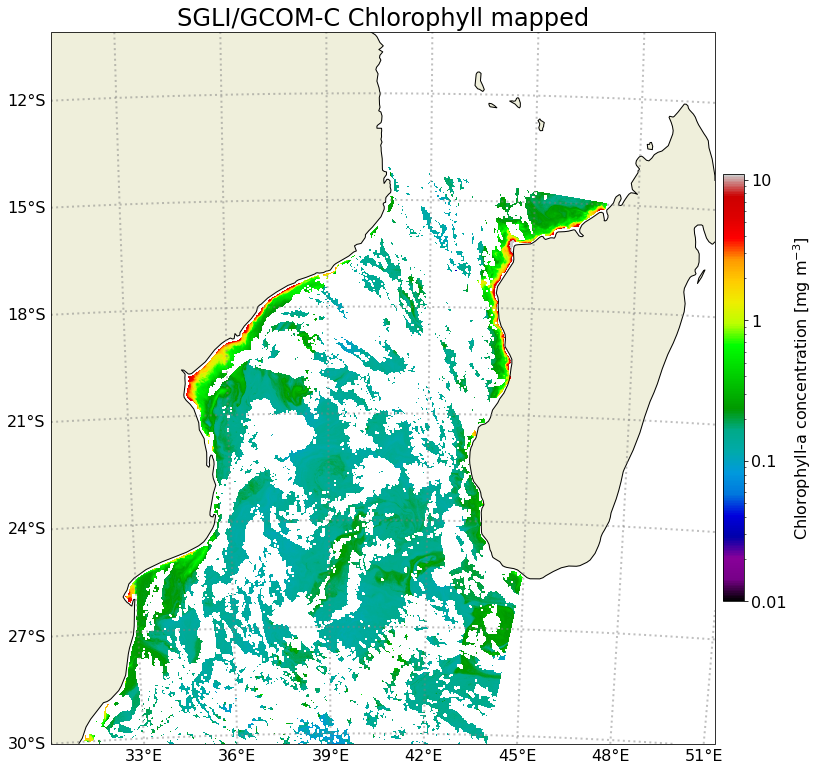

In [16]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs})

# --------
# img disp
# --------
m = ax.imshow(result, transform=crs, 
              extent=crs.bounds, 
              norm=colors.LogNorm(vmin=0.01, vmax=11), 
              cmap='nipy_spectral', origin='upper')
ax.set_title(f'SGLI/GCOM-C Chlorophyll mapped', size=24)
ax.coastlines()
ax.add_feature(cfeature.LAND)

# Colorbar
cb = fig.colorbar(m, ax=ax, shrink=0.6, pad=0.01, format='%g')
cb.set_label('Chlorophyll-a concentration [mg m$^{-3}$]')

# map gridlines 
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=True,
                  linewidth=2, 
                  color='gray', alpha=0.5, linestyle=':')
gl.top_labels  = False
gl.right_labels = False

plt.tight_layout()

# output file 
file = files[1].parent.joinpath(files[1].name.replace('.h5', '.png'))
fig.savefig(file)

<div class="alert alert-block alert-success"/div>
    <h2>Done!</h2>
  
--- 

#### And thank you for your attention! :) 
    We hope you are enjoying the training provided by A-ECOP for A-ECOPs.

# 5. Resources

[Go back to the "Table of contents"](#Table-of-contents)

1. [PyResample](https://pyresample.readthedocs.io/en/latest/installation.html#)
4. [Matplotlib](https://matplotlib.org/)
5. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/#)
7. [ECOPs Ocean Colour Training](https://github.com/Elgyii/ocean-colour-training-ecops-africa)